# eKYc ID Card Dewarping Algorithm

## First Step: ID-Card Segmentation
To segment the area of the ID-Card as the foreground apart from the background we propose two color-based segmentation methods. The first method is a fast method that segments easy samples which have a robust difference in color/intensity between the foreground and background based on applying Otsu's method on each channel of the HSV representation. After that, each channel is scored according to its likelihood of containing a valid segmentation. The second method is a slower method based on K-means clustering of the color space into two clusters (the foreground colors and the background colors). We also apply a method to determine whether the segmentation was successful or not.

Here is an example of an ID-card that we will use to demonstrate our method:

In [1]:
import cv2
from matplotlib import pyplot as plt

test_image = cv2.imread('test.jpeg')
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
plt.show()

### First Color-Based Segmentation Method
The first step is to resize the image if its maximum dimension exceeds a certain pre-defined number. Resizing is also a way to smooth out the differences in color and decrease the algorithm's runtime.

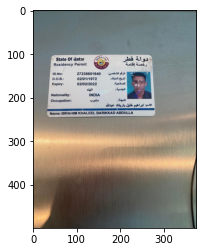

In [2]:
import numpy as np
from typing import Tuple, Union, Callable

COLOR_SEGMENTATION_MAXIMUM_DIMENSION = 500

def resize_image_max_dimension(image_bgr: np.ndarray,
                               target_max_dimension: int) -> Tuple[float, np.ndarray]:
    image_max_dimension = max(image_bgr.shape)
    if image_max_dimension > target_max_dimension:
        resize_factor = target_max_dimension / image_max_dimension
        resized_image = cv2.resize(image_bgr,
                                   (0, 0),
                                   fx=resize_factor,
                                   fy=resize_factor,
                                   interpolation=cv2.INTER_AREA)
    else:
        resize_factor = 1.0
        resized_image = np.array(image_bgr)
    return resize_factor, resized_image


resize_factor, resized_image = resize_image_max_dimension(test_image, COLOR_SEGMENTATION_MAXIMUM_DIMENSION)

plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
plt.show()

After resizing, we convert the image to the HSV representation.

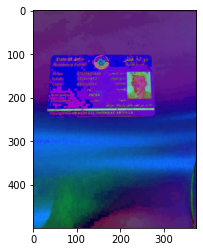

In [3]:
image_hsv = cv2.cvtColor(resized_image, cv2.COLOR_BGR2HSV)

plt.imshow(image_hsv)
plt.show()

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image_hsv[:, :, 0], plt.cm.gray)
axs[0].set_title('hue')
axs[1].imshow(image_hsv[:, :, 1], plt.cm.gray)
axs[1].set_title('saturation')
axs[2].imshow(image_hsv[:, :, 2], plt.cm.gray)
axs[2].set_title('value')
plt.show()

Now we apply Otsu's method on each channel.

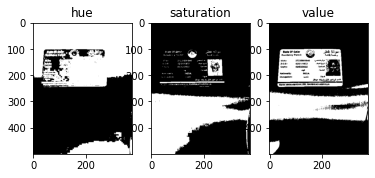

In [4]:
def otsu_threshold(image_gray: np.ndarray) -> np.ndarray:
    return cv2.threshold(image_gray,
                         0,
                         255,
                         cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

channels = [otsu_threshold(image_hsv[:, :, i]) for i in range(3)]

fig, axs = plt.subplots(1, 3)
axs[0].imshow(channels[0], plt.cm.gray)
axs[0].set_title('hue')
axs[1].imshow(channels[1], plt.cm.gray)
axs[1].set_title('saturation')
axs[2].imshow(channels[2], plt.cm.gray)
axs[2].set_title('value')
plt.show()

As we see above the most successful way to segment the image is based on differences in the intensities of the foreground and the background. Before we score the channels to choose the best, we will clean the images from noise and apply a closing morphology operation followed by a dilation to close the ID-card area if has any gaps. To clean the noise we will remove any connected component of size less than 10. This may be tweaked according to need.

In [5]:
BINARY_IMAGE_CLEANING_MAX_NOISE_SIZE = 10
BINARY_IMAGE_CLOSING_KERNEL_SIZE = 11
BINARY_IMAGE_DILATION_KERNEL_SIZE = 3

def dilate(image: np.ndarray,
           kernel_dimension_size: int) -> np.ndarray:
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,
                                       (kernel_dimension_size,
                                        kernel_dimension_size))
    return cv2.dilate(image, kernel)

def closing_morphology(image: np.ndarray,
                       kernel_dimension_size: int,
                       power: int) -> np.ndarray:
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,
                                       (kernel_dimension_size,
                                        kernel_dimension_size))
    image = cv2.dilate(image, kernel, iterations=power)
    return cv2.erode(image, kernel, iterations=power)

def clean_binary_image(binary_image: np.ndarray,
                       max_noise_size: int,
                       closing_kernel_size: int,
                       dilation_kernel_size: int) -> np.ndarray:
    labels_count, labeled_image, stats, centroids = cv2.connectedComponentsWithStats(binary_image, 8, cv2.CV_32S)
    new_image = np.zeros_like(binary_image)
    for i in range(1, labels_count):
        if stats[:, -1][i] < max_noise_size:
            continue
        new_image += np.array(labeled_image == i, np.uint8) * 255
    binary_image = closing_morphology(new_image, closing_kernel_size, 1)
    return dilate(binary_image, dilation_kernel_size)


channels = [clean_binary_image(channels[i], 
                               BINARY_IMAGE_CLEANING_MAX_NOISE_SIZE,
                               BINARY_IMAGE_CLOSING_KERNEL_SIZE,
                               BINARY_IMAGE_DILATION_KERNEL_SIZE) for i in range(3)]

fig, axs = plt.subplots(1, 3)
axs[0].imshow(channels[0], plt.cm.gray)
axs[0].set_title('hue')
axs[1].imshow(channels[1], plt.cm.gray)
axs[1].set_title('saturation')
axs[2].imshow(channels[2], plt.cm.gray)
axs[2].set_title('value')
plt.show()

For the scoring part, the following steps are performed:
1. In each channel, check if the ratio of the number of black pixels (background) to the are of the image is above a certain threshold. Otherwise the foreground-background separation is assumed to be unsuccessful in that channel.
2. In each channel, we want to find the region of connected components that is most likely to be the ID-Card region. This is done as follows:
    1. Filter out any region if the ratio of its size to the area of the image is below a certain threshold.
    2. Score the region by the difference between its width to height ratio and the width to height ratio of a real ID-card (1.575). The region of highest score is chosen.
3. Score each channel according to the following formula:
    1. The quantity `score1` is the ratio of the size of the region of the ID-card to the area of the convex hull of its points.
    2. The quantity `score2` is a measure of the linearity of the edges of the ID-card, this is computed by taking the contour of the region and dividng the contour into segments where each segment connects two corners. The linearity measure is calculated by computing the distance between a point on a segment and the line that passes through the endpoints of the segment.
4. The final score is a weighted sum of the quantities `score1` and `score2`.

We also correct the corner vertices in the contour because the ID-card sometimes has round corners which results in an incorrect extraction and dewarping of the ID-card edges. This is done by linearly interpolating the segments of the contour between the corners and then calculating the intersection points of these segments.

In [6]:
import math
from scipy.spatial import ConvexHull

MIN_BLACK_PIXELS_TO_AREA_RATIO = 0.1
ID_CARD_AREA_TO_IMAGE_AREA_MIN_RATIO = 0.125
EPSILON = 1e-6

SINGLE_POINT = 'point'
ORDINARY_LINE = 'ordinary'
HORIZONTAL_LINE = 'horizontal'
VERTICAL_LINE = 'vertical'

def compute_center_of_gravity(points: np.ndarray) -> np.ndarray:
    return np.array([np.mean(points[:, :1]), np.mean(points[:, 1:])])

def distance(point1: np.ndarray,
             point2: np.ndarray) -> float:
    return np.sqrt(np.sum(np.square(np.subtract(point1, point2))))

def find_furthest_point_from(point: np.ndarray,
                             points: np.ndarray) -> Tuple[np.ndarray, int]:
    max_distance = -1.0
    furthest_point = None
    furthest_point_index = -1
    for i in range(len(points)):
        p = points[i]
        point_distance = distance(point, p)
        if point_distance > max_distance:
            max_distance = point_distance
            furthest_point = p
            furthest_point_index = i
    return furthest_point, furthest_point_index

def adjust_angle_by_quadrant(angle: float,
                             point: tuple[int, int]) -> float:
    x, y = point
    if x < 0 and y > 0:
        return 180 - angle
    if x < 0 and y < 0:
        return 180 + angle
    if x > 0 and y < 0:
        return 360 - angle
    return angle

def compute_angle(origin: np.ndarray,
                  point: np.ndarray) -> float:
    x1, y1 = np.subtract(point, origin)
    if math.fabs(x1) > 1e-6:
        theta = math.fabs(math.atan(y1 / x1)) / math.pi * 180
    else:
        theta = 90
    return adjust_angle_by_quadrant(theta, (x1, y1))

def sort_points_anti_clockwise(origin: np.array,
                               points: np.array,
                               points_indices: list) -> Tuple[list, list]:
    point_angle_pairs = [[points[i], points_indices[i], compute_angle(points[i], origin)] for i in range(len(points))]
    point_angle_pairs.sort(key=lambda x: x[2])
    return [point for point, _, _ in point_angle_pairs], [point_i for _, point_i, _ in point_angle_pairs]

def find_point_by_maximality_criteria(points: np.ndarray,
                                      maximality_criteria: Callable[[np.ndarray], float]) -> Tuple[np.ndarray, int]:
    max_value = -1.0
    point_of_max_value = None
    point_index = -1
    for i in range(len(points)):
        p = points[i]
        value = maximality_criteria(p)
        if value > max_value:
            max_value = value
            point_of_max_value = p
            point_index = i
    return point_of_max_value, point_index

def find_convex_4_polygon_vertices(points: np.ndarray) -> Tuple[list, list]:
    center = compute_center_of_gravity(points)
    vertex1, vertex1_index = find_furthest_point_from(center, points)
    vertex2, vertex2_index = find_furthest_point_from(vertex1, points)
    vertex3, vertex3_index = find_point_by_maximality_criteria(points,
                                                               lambda p: distance_between_point_and_line(vertex1,
                                                                                                         vertex2,
                                                                                                         p))
    vertices = [vertex1, vertex2, vertex3]
    vertices_indices = [vertex1_index, vertex2_index, vertex3_index]
    vertices, vertices_indices = sort_points_anti_clockwise(center, vertices, vertices_indices)
    vertex4, vertex4_index = find_point_by_maximality_criteria(points,
                                                               lambda p: calculate_polygon_area(vertices[0],
                                                                                                vertices[1],
                                                                                                vertices[2],
                                                                                                p))
    return vertices + [vertex4], vertices_indices + [vertex4_index]

def get_contour_segments(contour: np.ndarray,
                         vertices_indices: list) -> list[np.ndarray]:
    contour_list = contour.tolist()
    segments = []
    for i in range(len(vertices_indices)):
        current_i = vertices_indices[i]
        next_i = vertices_indices[(i + 1) % len(vertices_indices)]
        if current_i < next_i:
            segment = np.array(contour_list[next_i:] + contour_list[:current_i], np.float)
        else:
            segment = np.array(contour_list[next_i:current_i], np.float)
        segments.append(segment)
    return segments

def enhance_vertices(contour: np.ndarray,
                     vertices_indices: list[int]) -> np.ndarray:
    segments = get_contour_segments(contour, vertices_indices)
    lines = [parametric_line_to_non_parametric(parametric_linear_regression(segment)) for segment in segments]
    return np.array([find_lines_intersection_point(lines[i - 1], lines[i]) for i in range(len(segments))], np.int)


def distance_between_point_and_line(line_initial_point: np.ndarray,
                                    line_terminal_point: np.ndarray,
                                    point: np.ndarray) -> float:
    x1, y1 = line_initial_point
    x2, y2 = line_terminal_point
    x0, y0 = point
    denominator = distance(line_initial_point, line_terminal_point)
    if denominator < EPSILON:
        return distance(line_initial_point, point)
    return abs((x2 - x1) * (y1 - y0) - (x1 - x0) * (y2 - y1)) / denominator

def linearity_error(segments: list[np.ndarray],
                    vertices: np.ndarray) -> float:
    total_error = 0
    n = 0
    for i in range(len(vertices)):
        current_vertex = vertices[i]
        next_vertex = vertices[(i + 1) % len(vertices)]
        segment = segments[i]
        for j in range(1, len(segment) - 1):
            total_error += distance_between_point_and_line(current_vertex, next_vertex, segment[j])
            n += 1
    return total_error / n

def find_largest_contour(image: np.ndarray) -> np.ndarray:
    contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    max_area = -1
    largest_contour = None
    for contour in contours:
        contour_area = cv2.moments(contour)['m00']
        if contour_area > max_area:
            max_area = contour_area
            largest_contour = contour
    return largest_contour.reshape(-1, 2)

def calculate_triangle_area(point1: np.ndarray,
                            point2: np.ndarray,
                            point3: np.ndarray) -> float:
    return np.fabs(0.5 * (point1[0] * (point2[1] - point3[1])
                          + point2[0] * (point3[1] - point1[1])
                          + point3[0] * (point1[1] - point2[1])))

def calculate_polygon_area(point1: np.ndarray,
                           point2: np.ndarray,
                           point3: np.ndarray,
                           base_point: np.ndarray):
    area1 = calculate_triangle_area(base_point, point1, point2)
    area2 = calculate_triangle_area(base_point, point2, point3)
    return area1 + area2

def estimate_parametric_slope_and_intercept(n: int, points: np.ndarray, axis: int = 0) -> Tuple[float, float]:
    coefficients = np.array([i + 1 for i in range(n)])
    sum1 = np.sum(points[:, axis] * coefficients)
    sum2 = np.sum(points[:, axis])
    slope = 12 * (sum1 - sum2 * (n + 1) / 2) / (n * (n + 1) * (n - 1))
    intercept = sum2 / n - slope * (n + 1) / 2
    return slope, intercept

def parametric_linear_regression(points: np.ndarray) -> Tuple[Tuple[float, float],
                                                              Tuple[float, float]]:
    n = len(points)

    slope_x, intercept_x = estimate_parametric_slope_and_intercept(n, points)
    slope_y, intercept_y = estimate_parametric_slope_and_intercept(n, points, 1)

    return (slope_x, intercept_x), (slope_y, intercept_y)

def parametric_line_to_non_parametric(parametric_line: Tuple[Tuple[float, float],
                                                             Tuple[float, float]]) -> Tuple[str, list[float]]:
    (slope_x, intercept_x), (slope_y, intercept_y) = parametric_line

    if slope_x == 0 and slope_y == 0:
        return SINGLE_POINT, [intercept_x, intercept_y]
    if slope_x == 0:
        return VERTICAL_LINE, [intercept_x]
    if slope_y == 0:
        return HORIZONTAL_LINE, [intercept_y]

    slope = slope_y / slope_x
    return ORDINARY_LINE, [slope, intercept_y - slope * intercept_x]

def find_lines_intersection_point(line1: Tuple[str, list[float]],
                                  line2: Tuple[str, list[float]]) -> Union[list[float], None]:
    type1, parameters1 = line1
    type2, parameters2 = line2

    if type1 == SINGLE_POINT and type2 == SINGLE_POINT:
        if np.max(np.abs(np.subtract(parameters1, parameters2))) < EPSILON:
            return parameters1
        else:
            return None

    if type1 == SINGLE_POINT and type2 == VERTICAL_LINE:
        if abs(parameters1[0] - parameters2[0]) < EPSILON:
            return parameters1
        else:
            return None

    if type1 == SINGLE_POINT and type2 == HORIZONTAL_LINE:
        if abs(parameters1[1] - parameters2[0]) < EPSILON:
            return parameters1
        else:
            return None

    if type1 == SINGLE_POINT and type2 == ORDINARY_LINE:
        regressed = parameters1[0] * parameters2[0] + parameters2[1]
        if abs(regressed - parameters1[1]) < EPSILON:
            return parameters1
        else:
            return None

    if type1 == VERTICAL_LINE and type2 == VERTICAL_LINE:
        if np.max(np.abs(np.subtract(parameters1, parameters2))) < EPSILON:
            return [parameters1[0], parameters1[0]]
        else:
            return None

    if type1 == VERTICAL_LINE and type2 == HORIZONTAL_LINE:
        return [parameters1[0], parameters2[0]]

    if type1 == VERTICAL_LINE and type2 == ORDINARY_LINE:
        return [parameters1[0], parameters1[0] * parameters2[0] + parameters2[1]]

    if type1 == HORIZONTAL_LINE and type2 == HORIZONTAL_LINE:
        if parameters1 == parameters2:
            return [parameters1[0], parameters1[0]]
        else:
            return None

    if type1 == HORIZONTAL_LINE and type2 == ORDINARY_LINE:
        return [(parameters1[0] - parameters2[1]) / parameters2[0], parameters1[0]]

    if type1 == ORDINARY_LINE and type2 == ORDINARY_LINE:
        x = (parameters2[1] - parameters1[1]) / (parameters1[0] - parameters2[0])
        return [x, parameters1[0] * x + parameters1[1]]

    return find_lines_intersection_point(line2, line1)


def compute_image_score_for_id_card_extraction(binary_image: np.ndarray,
                                               id_card_width_height_ratio: float) -> Tuple[float,
                                                                                           Union[np.ndarray, None]]:
    area = binary_image.shape[0] * binary_image.shape[1]
    black_pixels_count = np.count_nonzero(binary_image == 0)

    if black_pixels_count / area < ID_CARD_AREA_TO_IMAGE_AREA_MIN_RATIO:
        return 0.0, None

    labels_count, labeled_image, stats, centroids = cv2.connectedComponentsWithStats(binary_image, 8, cv2.CV_32S)
    if labels_count == 1:
        return 0.0, None

    labeled_image = np.transpose(labeled_image)
    sizes = stats[:, -1]
    max_size = sizes[1]
    max_score = 0.0
    best_coordinates = None
    best_label = 1
    best_size = sizes[1]
    for i in range(1, labels_count):
        if sizes[i] > max_size:
            max_size = sizes[i]
        coordinates = np.transpose(np.where(labeled_image == i))
        _, (width, height), _ = cv2.minAreaRect(coordinates)
        if width * height / area < ID_CARD_AREA_TO_IMAGE_AREA_MIN_RATIO:
            continue
        ratio = max(width / height, height / width)
        score = 1.0 / (1.0 + abs(ratio - id_card_width_height_ratio))
        if score > max_score:
            max_score = score
            best_coordinates = coordinates
            best_label = i
            best_size = sizes[i]

    if max_size / area < ID_CARD_AREA_TO_IMAGE_AREA_MIN_RATIO:
        return 0.0, None

    convex_hull = ConvexHull(best_coordinates)
    score1 = best_size / convex_hull.volume

    connected_component = np.array(np.transpose(labeled_image == best_label), np.uint8) * 255
    best_contour = find_largest_contour(connected_component)
    center_point = compute_center_of_gravity(best_contour)
    rectangle_vertices, rectangle_vertices_i = find_convex_4_polygon_vertices(best_contour)
    rectangle_vertices, rectangle_vertices_i = sort_points_anti_clockwise(center_point,
                                                                          rectangle_vertices,
                                                                          rectangle_vertices_i)
    rectangle_vertices = enhance_vertices(best_contour, rectangle_vertices_i)

    segments = get_contour_segments(best_contour, rectangle_vertices_i)

    score2 = 1 / (1 + linearity_error(segments, rectangle_vertices) ** 3)
    score2 = 2 * score2 / (1 + score2)

    return 0.25 * score1 + 0.75 * score2, rectangle_vertices

for channel_name, channel in zip(['hue', 'saturation', 'value'], channels):
    print(f'{channel_name}: {compute_image_score_for_id_card_extraction(channel, 1.575)[0]}')


hue: 0.24095477473586555
saturation: 0.1625683358728501
value: 0.9494372717960899


To see the process of the scoring step by step:

* We take he best region that matches ID-card width to height ratio.

In [7]:
area = np.prod(channels[2].shape)
labels_count, labeled_image, stats, centroids = cv2.connectedComponentsWithStats(channels[2], 8, cv2.CV_32S)

labeled_image = np.transpose(labeled_image)
sizes = stats[:, -1]
max_size = sizes[1]
max_score = 0.0
best_coordinates = None
best_label = 1
best_size = sizes[1]
for i in range(1, labels_count):
    if sizes[i] > max_size:
        max_size = sizes[i]
    coordinates = np.transpose(np.where(labeled_image == i))
    _, (width, height), _ = cv2.minAreaRect(coordinates)
    if width * height / area < ID_CARD_AREA_TO_IMAGE_AREA_MIN_RATIO:
        continue
    ratio = max(width / height, height / width)
    score = 1.0 / (1.0 + abs(ratio - 1.575))
    if score > max_score:
        max_score = score
        best_coordinates = coordinates
        best_label = i
        best_size = sizes[i]

labeled_image = np.transpose(labeled_image)
display_image = np.zeros_like(channels[0])
for y in range(channels[2].shape[0]):
    for x in range(channels[2].shape[1]):
        if labeled_image[y, x] == best_label:
            display_image[y, x] = 255
        else:
            display_image[y, x] = 0

plt.imshow(display_image, plt.cm.gray)
plt.show()

* The convex hull of area is then calculated.

In [8]:
convex_hull = ConvexHull(best_coordinates)
convex_hull_vertices = [np.int0(convex_hull.points[i]) for i in convex_hull.vertices]

display_image = cv2.cvtColor(display_image, cv2.COLOR_GRAY2RGB)
for pt in convex_hull_vertices:
    cv2.circle(display_image, tuple(pt), 6, (0, 255, 0), -1)

plt.imshow(display_image)
plt.show()

* We then take the contour of the ID-Card.

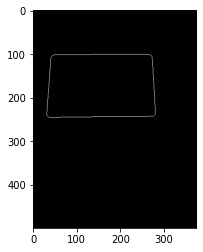

In [9]:
connected_component = np.array(np.transpose(labeled_image == best_label), np.uint8) * 255
best_contour = find_largest_contour(connected_component)

display_image = np.zeros_like(channels[0])

for y, x in best_contour:
    display_image[y, x] = 255

plt.imshow(display_image, plt.cm.gray)
plt.show()

* Then we calculate the four corners of the contour assuming it is convex (this is an approximation).

In [10]:
rectangle_vertices, rectangle_vertices_i = find_convex_4_polygon_vertices(best_contour)

display_image = cv2.cvtColor(display_image, cv2.COLOR_GRAY2RGB)
for pt in rectangle_vertices:
    cv2.circle(display_image, (pt[1], pt[0]), 6, (0, 255, 0), -1)

plt.imshow(display_image)
plt.show()

* Finally we enchance the corner points using linear interploation and calculating intersections.

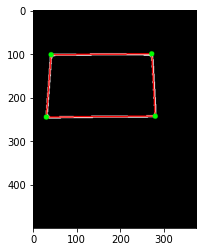

In [11]:
center_point = compute_center_of_gravity(best_contour)
rectangle_vertices, rectangle_vertices_i = sort_points_anti_clockwise(center_point,
                                                                      rectangle_vertices,
                                                                      rectangle_vertices_i)
rectangle_vertices = enhance_vertices(best_contour, rectangle_vertices_i)

display_image = np.zeros_like(channels[0])

for y, x in best_contour:
    display_image[y, x] = 255
display_image = dilate(display_image, 5)

display_image = cv2.cvtColor(display_image, cv2.COLOR_GRAY2RGB)

cv2.line(display_image, rectangle_vertices[0][::-1], rectangle_vertices[1][::-1], (255, 0, 0), 2)
cv2.line(display_image, rectangle_vertices[1][::-1], rectangle_vertices[2][::-1], (255, 0, 0), 2)
cv2.line(display_image, rectangle_vertices[2][::-1], rectangle_vertices[3][::-1], (255, 0, 0), 2)
cv2.line(display_image, rectangle_vertices[3][::-1], rectangle_vertices[0][::-1], (255, 0, 0), 2)

for pt in rectangle_vertices:
    cv2.circle(display_image, (pt[1], pt[0]), 6, (0, 255, 0), -1)

plt.imshow(display_image)
plt.show()

Before the final step, we take the vertices of the segmented ID-card from the channel of highest score.

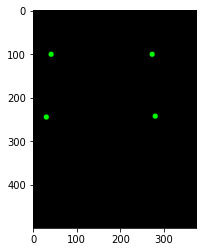

In [12]:
hue_info = compute_image_score_for_id_card_extraction(channels[0], 1.575)
saturation_info = compute_image_score_for_id_card_extraction(channels[1], 1.575)
value_info = compute_image_score_for_id_card_extraction(channels[2], 1.575)

components = [hue_info, saturation_info, value_info]
components.sort(key=lambda x: x[0])

rectangle_vertices = components[-1][1]

display_image = cv2.cvtColor(np.zeros_like(channels[0]), cv2.COLOR_GRAY2RGB)

for pt in rectangle_vertices:
    cv2.circle(display_image, tuple(pt), 6, (0, 255, 0), -1)
    
plt.imshow(display_image, plt.cm.gray)
plt.show()

The final step is to correct the corner vertices order so that the width of the area is larger than its height and so that after dewarping the ID-card is not flipped horizontally. Finally, the ID-Card is dewarped using these vertices.

In [13]:
def warp_perspective(image: np.ndarray,
                     original_points: list[Tuple[float, float]],
                     target_points: list[Tuple[int, int]],
                     target_width: int,
                     target_height: int) -> np.ndarray:
    original_points = np.float32(original_points)
    target_points = np.float32(target_points)
    perspective_transform_matrix = cv2.getPerspectiveTransform(original_points, target_points)
    return cv2.warpPerspective(image,
                               perspective_transform_matrix,
                               (target_width, target_height),
                               flags=cv2.INTER_NEAREST)

def triangle_area(point1: Tuple[float, float],
                  point2: Tuple[float, float],
                  point3: Tuple[float, float]) -> float:
    x1, y1 = point1
    x2, y2 = point2
    x3, y3 = point3
    return math.fabs(0.5 * (x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2)))

def calculate_4_polygon_area(point1: Tuple[float, float],
                             point2: Tuple[float, float],
                             point3: Tuple[float, float],
                             point4: Tuple[float, float]) -> float:
    return triangle_area(point1, point2, point3) + \
           triangle_area(point1, point4, point3)

def estimate_card_width_height_from_vertices(vertices: list[Tuple[float, float]],
                                             id_card_width_height_ratio: float) -> Tuple[int, int]:
    area = calculate_4_polygon_area(*vertices)
    height = math.sqrt(area / id_card_width_height_ratio)
    width = id_card_width_height_ratio * height
    return int(math.floor(width)), int(math.floor(height))

def correct_perspective(image: np.ndarray,
                        original_vertices: list[Tuple[float, float]],
                        id_card_width_height_ratio: float) -> np.ndarray:
    target_width, target_height = estimate_card_width_height_from_vertices(original_vertices,
                                                                           id_card_width_height_ratio)
    target_rectangle_vertices = [(0, 0),
                                 (target_width - 1, 0),
                                 (target_width - 1, target_height - 1),
                                 (0, target_height - 1)]
    return warp_perspective(image,
                            original_vertices,
                            target_rectangle_vertices,
                            target_width,
                            target_height)

def auto_correct_vertices_order(vertices: np.ndarray) -> np.ndarray:
    point1, point2, point3, point4 = vertices
    side1_length = distance(point1, point2)
    corresponding_side1_length = distance(point4, point3)
    side2_length = distance(point2, point3)
    corresponding_side2_length = distance(point1, point4)
    if max(side1_length, corresponding_side1_length) < min(side2_length, corresponding_side2_length):
        return np.array([point2,
                         point3,
                         point4,
                         point1])
    return vertices

rectangle_vertices = auto_correct_vertices_order(rectangle_vertices)
corrected_perspective = correct_perspective(test_image,
                                            [(x / resize_factor, y / resize_factor)
                                             for x, y in rectangle_vertices],
                                            1.575)


plt.imshow(cv2.cvtColor(corrected_perspective, cv2.COLOR_BGR2RGB))
plt.show()

### Second Color-Based Segmentation Method
Similarly to the first method, the first step is to resize the image if its maximum dimension exceeds a certain pre-defined number.

In [14]:
test_image = cv2.imread('test2.jpg')
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
plt.show()

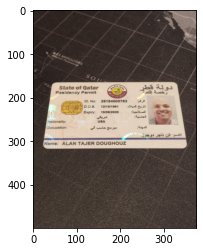

In [15]:
resize_factor, resized_image = resize_image_max_dimension(test_image, COLOR_SEGMENTATION_MAXIMUM_DIMENSION)

plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
plt.show()

Then the image is converted to the HSV representation. Afterwards, K-means clustering is performed to find two clusters of colors (the foreground colors and the background colors). Since an image has a high dimensionality, a less accurate minibatch K-means algorithm is used which is much faster.

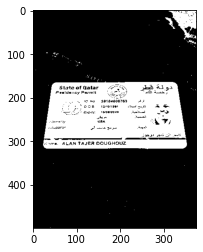

In [16]:
from sklearn.cluster import MiniBatchKMeans

K_MEANS_BATCH_SIZE_PERCENTAGE = 0.0025

image_hsv = cv2.cvtColor(resized_image, cv2.COLOR_BGR2HSV)

color_points = image_hsv.reshape(-1, image_hsv.shape[-1])
k_means = MiniBatchKMeans(n_clusters=2, batch_size=int(len(color_points) * K_MEANS_BATCH_SIZE_PERCENTAGE))
k_means.fit(color_points)
clustered_image = np.array(k_means.labels_, np.uint8).reshape(image_hsv.shape[0:2])
clustered_image *= 255

plt.imshow(clustered_image, plt.cm.gray)
plt.show()

The problem is that sometimes the K-means algorithm labels the background as the forground and vice-versa. To mitigate this issue, the image is inverted according to some rules which is called threshold correction. If the image has very few black pixels, then it is assumed that there are no background pixels (the image is only the full id-cared) or that the K-means algorithm failed to separate the foreground colors from the background colors as two different clusters. Afterwards, since in the correct labeling, the background must be black on the margins, the percentage of white pixels in the margins are calculated and if it exceeds a certain threshold then that means the labeling is incorrect and that the image must be inverted.

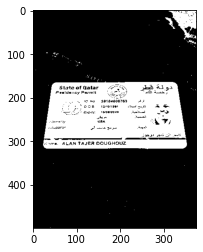

In [17]:
THRESHOLD_CORRECTION_MARGIN_SIZE = 20
WHITE_BORDER_PIXEL_RATIO = 0.65

def correct_threshold(binary_image: np.ndarray) -> np.ndarray:
    black_pixels_count = np.count_nonzero(binary_image == 0)
    id_card_pixels_count = ID_CARD_AREA_TO_IMAGE_AREA_MIN_RATIO * binary_image.shape[0] * binary_image.shape[1]
    if black_pixels_count < id_card_pixels_count:
        return binary_image
    margin_size = THRESHOLD_CORRECTION_MARGIN_SIZE
    margin_colors = np.concatenate([binary_image[:, :margin_size].ravel(),
                                    binary_image[:margin_size, :].ravel(),
                                    binary_image[:, -margin_size:].ravel(),
                                    binary_image[-margin_size:, :].ravel()])
    if np.mean(margin_colors) / 255.0 > WHITE_BORDER_PIXEL_RATIO:
        return 255 - binary_image
    return binary_image

clustered_image = correct_threshold(clustered_image)

plt.imshow(clustered_image, plt.cm.gray)
plt.show()

Finally, the other steps are similar to the first method.

In [18]:
ID_CARD_FINAL_WIDTH = 750

def find_best_contour(image: np.ndarray,
                      id_card_width_height_ratio: float) -> Union[np.ndarray, None]:
    contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    image_area = image.shape[0] * image.shape[1]
    best_contour = None
    max_score = 0.0
    for contour in contours:
        _, (width, height), _ = cv2.minAreaRect(contour)
        area = width * height
        if area / image_area < ID_CARD_AREA_TO_IMAGE_AREA_MIN_RATIO:
            continue
        ratio = max(width / height, height / width)
        score = 1.0 / (1.0 + abs(ratio - id_card_width_height_ratio))
        if score > max_score:
            max_score = score
            best_contour = contour
    if best_contour is None:
        return None
    return best_contour.reshape(-1, 2)

def resize_id_card_to_final_dimensions(id_card_image: np.ndarray, id_card_width_height_ratio: float) -> np.ndarray:
    id_card_final_height = int(math.floor(ID_CARD_FINAL_WIDTH / id_card_width_height_ratio))
    return cv2.resize(id_card_image, (ID_CARD_FINAL_WIDTH, id_card_final_height), cv2.INTER_AREA)


clustered_image = clean_binary_image(clustered_image,
                                         BINARY_IMAGE_CLEANING_MAX_NOISE_SIZE,
                                         BINARY_IMAGE_CLOSING_KERNEL_SIZE,
                                         BINARY_IMAGE_DILATION_KERNEL_SIZE)
best_contour = find_best_contour(clustered_image, 1.575)

center_point = compute_center_of_gravity(best_contour)
rectangle_vertices, rectangle_vertices_i = find_convex_4_polygon_vertices(best_contour)
rectangle_vertices, rectangle_vertices_i = sort_points_anti_clockwise(center_point,
                                                                      rectangle_vertices,
                                                                      rectangle_vertices_i)
rectangle_vertices = enhance_vertices(best_contour, rectangle_vertices_i)
rectangle_vertices = auto_correct_vertices_order(rectangle_vertices)

corrected_perspective = correct_perspective(test_image,
                                            [(x / resize_factor, y / resize_factor)
                                             for x, y in rectangle_vertices],
                                            1.575)

result = resize_id_card_to_final_dimensions(corrected_perspective, 1.575)

plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.show()